In [34]:
!pip install pennylane
!pip install pennylane-qulacs
!pip install qulacs



In [35]:
from pennylane import qaoa
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
import networkx as nx


In [36]:
H = qml.Hamiltonian([1, 1, 0.5], [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)])
print(H)

1 * X(0) + 1 * Z(1) + 0.5 * (X(0) @ X(1))


In [37]:
dev = qml.device("default.qubit", wires=2)

t = 1
n = 2


@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]


print(qml.draw(circuit, level="device")())


0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


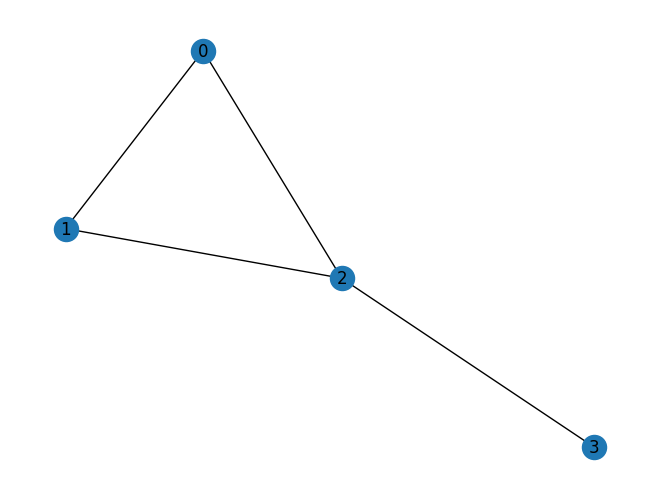

In [38]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)

nx.draw(graph, with_labels=True, pos=positions)
plt.show()


In [39]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [40]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [41]:
wires = range(4)
depth = 2


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [42]:
dev = qml.device("qulacs.simulator", wires=wires)


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [43]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)


In [44]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


In [45]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


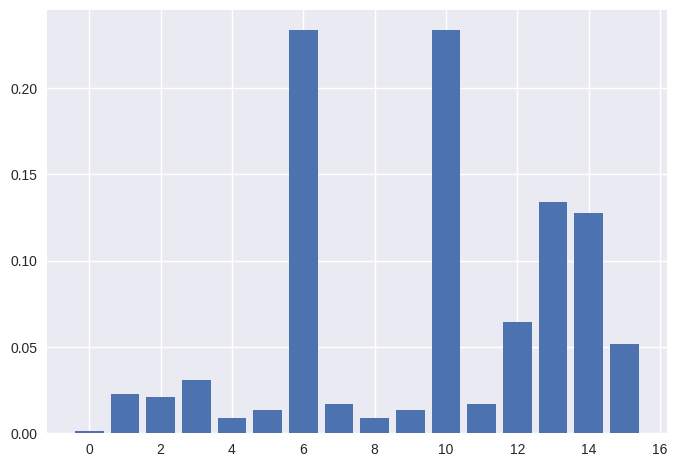

In [46]:
plt.style.use("seaborn-v0_8")
plt.bar(range(2 ** len(wires)), probs)
plt.show()